### 【問題1】公式チュートリアルモデルを分担して実行


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

音声コマンドデータセットをインポートする
音声コマンドデータセットの一部をダウンロードするスクリプトを作成します。元のデータセットは、30の異なる単語を言っている人々の105,000を超えるWAVオーディオファイルで構成されています。このデータはGoogleによって収集され、CC BYライセンスの下でリリースされました。自分の声を5分間提供することで、データの改善に役立てることができます。

データセットの一部を使用して、データの読み込みにかかる時間を節約します。 mini_speech_commands.zipを抽出し、 mini_speech_commands.zipを使用してtf.dataます。

In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')  #WAVデータを保管しているフォルダを指定
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [ ]:
# data/mini_speech_commands内のフォルダ・ファイルの名前のリストを入手する
commands = np.array(tf.io.gfile.listdir(str(data_dir)))  
#print(data_dir)
#print(str(data_dir))
#print(tf.io.gfile.listdir(str(data_dir)))
#print('Commands:',commands)
#Read meファイルは含まないようにする。
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['go' 'stop' 'left' 'no' 'yes' 'down' 'up' 'right']


オーディオファイルをリストに抽出し、シャッフルします。

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*') #Returns a list of files that match the given pattern(s).
#print(str(data_dir)) → data/mini_speech_commands
#print(type(filenames)) → List型

filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)  #ファイル名の数をサンプル数とする。
print('Number of total examples:', num_samples)
print('Number of examples per label:',
len(tf.io.gfile.listdir(str(data_dir/commands[0]))))  #Returns a list of entries contained within a directory.
print('Example file tensor:', filenames[0])

#８種類の単語、各１０００つのデータがDLされている。

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/left/2e30f9a5_nohash_0.wav', shape=(), dtype=string)


それぞれ80:10:10の比率を使用して、ファイルをトレーニング、検証、およびテストセットに分割します。

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800



オーディオファイルとそのラベルの読み取り
オーディオファイルは、最初はバイナリファイルとして読み取られ、数値テンソルに変換する必要があります。
オーディオファイルをロードするには、 tf.audio.decode_wavを使用しtf.audio.decode_wav 。これは、WAVでエンコードされたオーディオをテンソルおよびサンプルレートとして返します。
WAVファイルには、1秒あたりのサンプル数が設定された時系列データが含まれています。各サンプルは、その特定の時間におけるオーディオ信号の振幅を表します。 mini_speech_commandsのファイルのように、16ビットシステムでは、値の範囲はmini_speech_commands（※-32768 to 32767. ）です。このデータセットのサンプルレートは16kHzです。 tf.audio.decode_wavは、値を[-1.0、1.0]の範囲に正規化することに注意してください。

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)  #WAVでエンコードされたオーディオをテンソルおよびサンプルレートとして返します。
  print(audio.shape)
  return tf.squeeze(audio, axis=-1)

#tf.squeezeはsizeが1の次元を削除し次元数を減らすAPI
#第二引数を指定した場合は指定したindexの次元かつそこがsizeが1であるならば次元数を減らします。

各WAVファイルのラベルはその親ディレクトリです。

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

WAVファイルのファイル名を受け取り、教師ありトレーニング用のオーディオとラベルを含むタプルを出力するメソッドを定義しましょう。

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)  #WAVファイルの読み込み
  waveform = decode_audio(audio_binary) #WAVをテンソルにする。
  return waveform, label

次に、 process_pathを適用してトレーニングセットを構築し、オーディオとラベルのペアを抽出して結果を確認します。後で同様の手順を使用して、検証セットとテストセットを作成します。

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)  #画像のパスがまとまったデータ型になる（tf.data.dataset)。イテラブルなオブジェクトとして使える。
#参考:https://zenn.dev/tokyoyoshida/articles/5c3270ce0d4c91
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE) #tf.data.dataset型のmapメソッドで音声データが読み込める。
#↑waveform_dsには音声データが詰まっている。

(None, None)


いくつかのオーディオ波形とそれに対応するラベルを調べてみましょう。

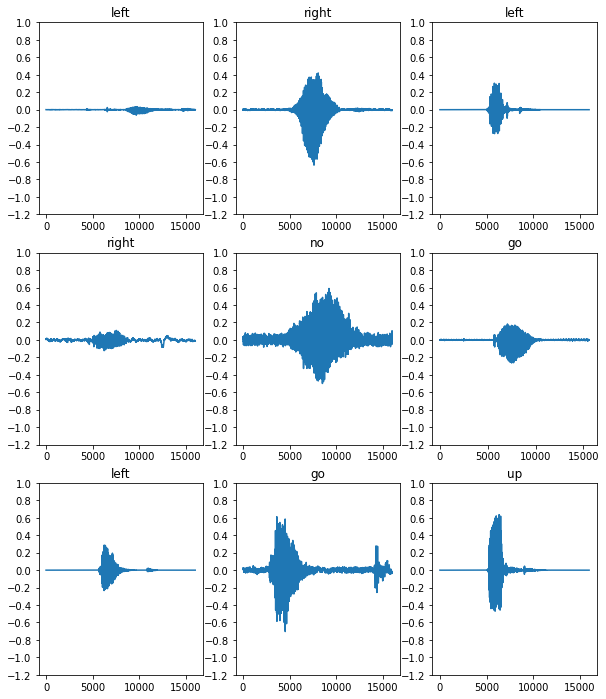

In [ ]:
rows = 3
cols = 3
n = rows*cols #表示させたい波形の数
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)): #.take(n) n個のデータを持ってくる。
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

スペクトログラム

波形をスペクトログラムに変換します。スペクトログラムは、時間の経過に伴う周波数の変化を示し、2D画像として表すことができます。これは、短時間フーリエ変換（STFT）を適用して、オーディオを時間-周波数領域に変換することで実行できます。

フーリエ変換（ tf.signal.fft ）は、信号をそのコンポーネント周波数に変換しますが、すべての時間情報を失います。 STFT（ tf.signal.stft ）は、信号を時間ウィンドウに分割し、各ウィンドウでフーリエ変換を実行して、時間情報を保持し、標準の畳み込みを実行できる2Dテンソルを返します。

STFTは、大きさと位相を表す複素数の配列を生成します。しかし、あなただけ適用することにより導出することができ、このチュートリアルのための大きさが必要ですtf.absの出力にtf.signal.stft 。

選択しframe_lengthとframe_step生成スペクトログラム「画像」は、ほぼ正方形であるというようなパラメータを。 STFTパラメータの選択の詳細については、オーディオ信号処理に関するこのビデオを参照してください。

また、波形の長さを同じにして、スペクトログラム画像に変換したときに結果の寸法が同じになるようにする必要があります。これは、1秒より短いオーディオクリップをゼロパディングするだけで実行できます。

In [ ]:
def get_spectrogram(waveform):  #waveformにはwaveform_dsのデータが送られる。
  # Padding for files with less than 16000 samples
  # 横軸が16000分のshapeが無い場合、ゼロで埋める。
  #print(tf.shape(waveform))
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
   
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)  #tf.cast( 変換したいもの , 変換後の型 )
  equal_length = tf.concat([waveform, zero_padding], 0)  #行方向に結合する
  spectrogram = tf.signal.stft(  #短時間フーリエ変換してスペクトログラムを作成する。
      equal_length, frame_length=255, frame_step=128) 
      #frame_length : An integer scalar Tensor. The window length in samples.
      #frame_step : An integer scalar Tensor. The number of samples to step.

  spectrogram = tf.abs(spectrogram)  #tf.abs 絶対値を取る。

  return spectrogram

次に、データを調べます。データセットからの1つの例の波形、スペクトログラム、および実際のオーディオを比較します。

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: go
Waveform shape: (15604,)
Spectrogram shape: (124, 129)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: go
Waveform shape: (15702,)
Spectrogram shape: (124, 129)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


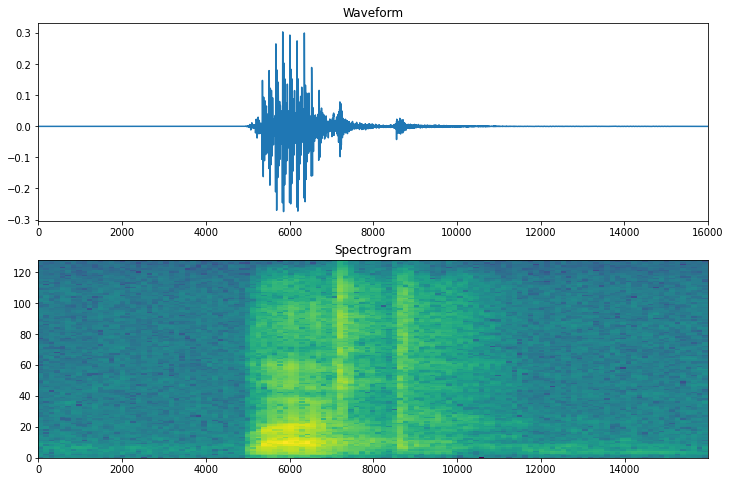

In [ ]:
def plot_spectrogram(spectrogram, ax):  #スペクトログラムの表示
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())  #振幅波形の表示
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])  #スペクトログラムの表示
axes[1].set_title('Spectrogram')
plt.show()

次に、波形データセットを変換して、スペクトログラム画像とそれに対応するラベルを整数IDとして使用します。

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(  #機械学習に使うスペクトラム画像がまとまったもの）
                                 
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

print(spectrogram_ds)

<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>


データセットのさまざまなサンプルのスペクトログラム「画像」を調べます。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


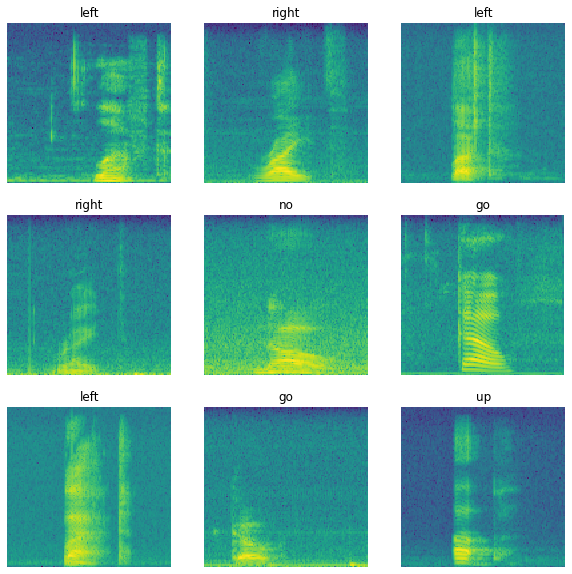

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

モデルを構築してトレーニングする


これで、モデルを作成してトレーニングできます。ただし、その前に、検証セットとテストセットでトレーニングセットの前処理を繰り返す必要があります。

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

(None, None)
(None, None)


モデルトレーニングのトレーニングセットと検証セットをバッチ処理します。

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

データセットのcache()およびprefetch()操作を追加して、モデルのトレーニング中の読み取りレイテンシーを削減します

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

モデルでは、オーディオファイルをスペクトログラム画像に変換したため、単純な畳み込みニューラルネットワーク（CNN）を使用します。モデルには、次の追加の前処理レイヤーもあります。

入力をダウンサンプリングしてモデルのトレーニングを高速化するためのResizingレイヤー。
平均と標準偏差に基づいて画像内の各ピクセルを正規Normalizationするための正規Normalizationレイヤー。
Normalizationレイヤーの場合、集計統計（平均と標準偏差）を計算するために、最初にそのadaptメソッドをトレーニングデータで呼び出す必要があります。

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)  #Commandsの中身 ['go' 'stop' 'left' 'no' 'yes' 'down' 'up' 'right']

#正規化レイヤーの準備
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x)) #平均と標準偏差を計算するために事前にxを呼び出す

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), #Resizingレイヤー: 入力をダウンサンプリングしてモデルのトレーニングを高速化する
    norm_layer, #正規化レイヤー
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)        

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 41s 400ms/step - loss: 1.9063 - accuracy: 0.3064 - val_loss: 1.2964 - val_accuracy: 0.5663
Epoch 2/10
100/100 [==============================] - 21s 207ms/step - loss: 1.2463 - accuracy: 0.5625 - val_loss: 0.9026 - val_accuracy: 0.7088
Epoch 3/10
100/100 [==============================] - 21s 206ms/step - loss: 0.9303 - accuracy: 0.6724 - val_loss: 0.7296 - val_accuracy: 0.7550
Epoch 4/10
100/100 [==============================] - 21s 207ms/step - loss: 0.7728 - accuracy: 0.7302 - val_loss: 0.6580 - val_accuracy: 0.7700
Epoch 5/10
100/100 [==============================] - 21s 207ms/step - loss: 0.6411 - accuracy: 0.7790 - val_loss: 0.6060 - val_accuracy: 0.7850
Epoch 6/10
100/100 [==============================] - 21s 207ms/step - loss: 0.5519 - accuracy: 0.8054 - val_loss: 0.5740 - val_accuracy: 0.7987
Epoch 7/10
100/100 [==============================] - 21s 206ms/step - loss: 0.5130 - accuracy: 0.8267 - val_loss: 0.5601 - val_ac

トレーニングと検証の損失曲線をチェックして、トレーニング中にモデルがどのように改善されたかを確認しましょう。

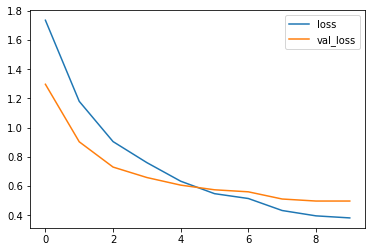

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 85%


混同行列を表示する
混同行列は、モデルがテストセット内の各コマンドでどの程度うまく機能したかを確認するのに役立ちます。

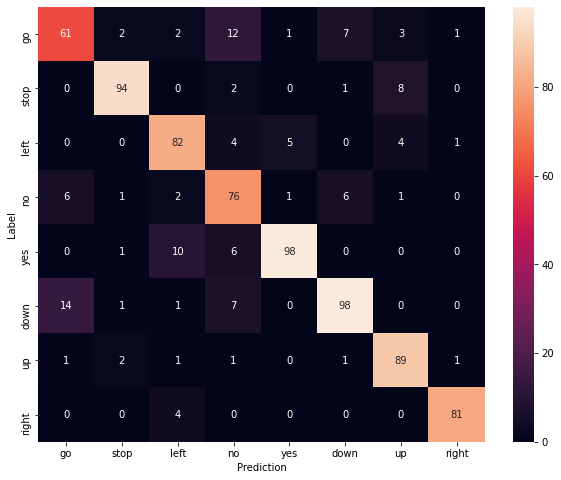

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

オーディオファイルで推論を実行する
最後に、「いいえ」と言っている人の入力オーディオファイルを使用して、モデルの予測出力を確認します。モデルのパフォーマンスはどれくらいですか？

(None, None)


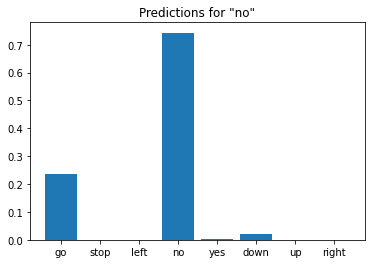

In [ ]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

### 【問題3】Iris（2値分類）をKerasで学習

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

K.clear_session( )

# データセットの読み込み
#df = pd.read_csv("Iris.csv")
df = pd.read_csv('drive/My Drive/DIVE INTO CODE/Iris.csv', dtype = None)

# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor") | (df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
# NumPy 配列に変換
X = np.array(X)
y = np.array(y)
# ラベルを数値に変換
y[y == "Iris-versicolor"] = 0
y[y == "Iris-virginica"] = 1
y = y.astype(np.int64)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#モデルの設計
model = keras.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1:]))) 
model.add(layers.Dense(128, activation='relu')) 
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

Mounted at /content/drive
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 38,337
Trainable params: 38,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 20

optimizer = keras.optimizers.Adam()
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = keras.losses.BinaryCrossentropy(from_logits=True)
metrics=['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS)#, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)

y_pred = model.predict(X_test)

scores = model.evaluate(X_test, y_test, verbose=1)
print("test loss", scores[0])
print("test acc", scores[1])

Epoch 1/20
2/2 [==============================] - 1s 175ms/step - loss: 0.6420 - accuracy: 0.5104 - val_loss: 0.6128 - val_accuracy: 0.9375
Epoch 2/20
2/2 [==============================] - 0s 40ms/step - loss: 0.5991 - accuracy: 0.8958 - val_loss: 0.6607 - val_accuracy: 0.3750
Epoch 3/20
2/2 [==============================] - 0s 38ms/step - loss: 0.5956 - accuracy: 0.5521 - val_loss: 0.6660 - val_accuracy: 0.3750
Epoch 4/20
2/2 [==============================] - 0s 40ms/step - loss: 0.5791 - accuracy: 0.5833 - val_loss: 0.6029 - val_accuracy: 0.6875
Epoch 5/20
2/2 [==============================] - 0s 35ms/step - loss: 0.5496 - accuracy: 0.8438 - val_loss: 0.5562 - val_accuracy: 1.0000
Epoch 6/20
2/2 [==============================] - 0s 36ms/step - loss: 0.5519 - accuracy: 0.9062 - val_loss: 0.5372 - val_accuracy: 1.0000
Epoch 7/20
2/2 [==============================] - 0s 38ms/step - loss: 0.5247 - accuracy: 0.9583 - val_loss: 0.5505 - val_accuracy: 0.8125
Epoch 8/20
2/2 [==========

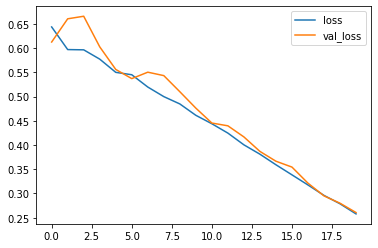

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### 【問題4】Iris（多値分類）をKerasで学習

In [ ]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを3値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from google.colab import drive
drive.mount('/content/drive')

K.clear_session( )

# データセットの読み込み
#df = pd.read_csv("Iris.csv")
df = pd.read_csv('drive/My Drive/DIVE INTO CODE/Iris.csv', dtype = None)

# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
# NumPy 配列に変換
X = np.array(X)
y = np.array(y)
# ラベルを数値に変換
y[y == "Iris-versicolor"] = 0
y[y == "Iris-virginica"] = 1
y[y == "Iris-setosa"] = 2
y = y.astype(np.int64)[:, np.newaxis]
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#モデルの設計
model = keras.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1:]))) 
model.add(layers.Dense(128, activation='relu')) 
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(3, activation='softmax')) 

model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 38,403
Trainable params: 38,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 20

optimizer = keras.optimizers.Adam()
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
#loss = keras.losses.BinaryCrossentropy(from_logits=True)
metrics=['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)

y_pred = model.predict(X_test)

scores = model.evaluate(X_test, y_test, verbose=1)
print("test loss", scores[0])
print("test acc", scores[1])

Epoch 1/20
3/3 [==============================] - 1s 103ms/step - loss: 1.1779 - accuracy: 0.2552 - val_loss: 1.0002 - val_accuracy: 0.5417
Epoch 2/20
3/3 [==============================] - 0s 22ms/step - loss: 0.9788 - accuracy: 0.5846 - val_loss: 0.8976 - val_accuracy: 0.7083
Epoch 3/20
3/3 [==============================] - 0s 21ms/step - loss: 0.8904 - accuracy: 0.6484 - val_loss: 0.8160 - val_accuracy: 0.7083
Epoch 4/20
3/3 [==============================] - 0s 22ms/step - loss: 0.8069 - accuracy: 0.6836 - val_loss: 0.7432 - val_accuracy: 0.7083
Epoch 5/20
3/3 [==============================] - 0s 20ms/step - loss: 0.7431 - accuracy: 0.7318 - val_loss: 0.6836 - val_accuracy: 0.7917
Epoch 6/20
3/3 [==============================] - 0s 22ms/step - loss: 0.6576 - accuracy: 0.8854 - val_loss: 0.6171 - val_accuracy: 0.7083
Epoch 7/20
3/3 [==============================] - 0s 25ms/step - loss: 0.6047 - accuracy: 0.8802 - val_loss: 0.5596 - val_accuracy: 0.7917
Epoch 8/20
3/3 [==========

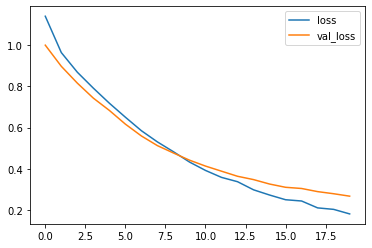

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

【問題5】House PricesをKerasで学習

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from google.colab import drive
drive.mount('/content/drive')

K.clear_session( )

# データセットの読み込み
#df = pd.read_csv("train.csv")
df = pd.read_csv('drive/My Drive/DIVE INTO CODE/train.csv', dtype = None)

# データフレームから条件抽出
y = df[['SalePrice']]
X = df[['GrLivArea','YearBuilt']]
y = np.array(np.log1p(y))
X = np.array(np.log1p(X))

# trainとtestに分割
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = \
train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#モデルの設計
model = keras.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1:]))) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(1)) 

model.summary()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 20

optimizer = keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop(0.001)
#optimizer = tf.train.RMSPropOptimizer
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = keras.losses.mean_squared_error#(from_logits=True)
loss = keras.losses.mse
#loss = keras.losses.BinaryCrossentropy(from_logits=True)
#metrics=['accuracy']
metrics=['mae']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS)#, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)

y_pred = model.predict(X_test)

scores = model.evaluate(X_test, y_test, verbose=1)
print("test mse", scores[0])
#print("test acc", scores[1])

Epoch 1/20
30/30 [==============================] - 1s 7ms/step - loss: 87.5842 - mae: 9.0683 - val_loss: 0.5529 - val_mae: 0.7005
Epoch 2/20
30/30 [==============================] - 0s 2ms/step - loss: 0.9168 - mae: 0.8147 - val_loss: 0.2449 - val_mae: 0.4433
Epoch 3/20
30/30 [==============================] - 0s 2ms/step - loss: 0.2184 - mae: 0.3907 - val_loss: 0.0772 - val_mae: 0.2015
Epoch 4/20
30/30 [==============================] - 0s 3ms/step - loss: 0.0719 - mae: 0.1981 - val_loss: 0.0734 - val_mae: 0.1987
Epoch 5/20
30/30 [==============================] - 0s 3ms/step - loss: 0.0824 - mae: 0.2099 - val_loss: 0.0709 - val_mae: 0.1993
Epoch 6/20
30/30 [==============================] - 0s 3ms/step - loss: 0.0761 - mae: 0.2074 - val_loss: 0.0716 - val_mae: 0.1985
Epoch 7/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0708 - mae: 0.1978 - val_loss: 0.0703 - val_mae: 0.2006
Epoch 8/20
30/30 [==============================] - 0s 2ms/step - loss: 0.0721 - mae: 0.1

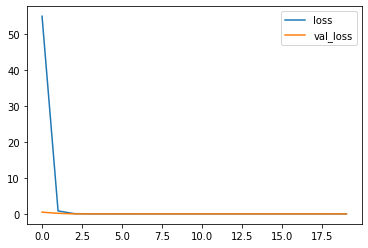

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### 【問題6】MNISTをKerasで学習

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
# MNISTデータセットのダウンロード
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()
#X = X[:, np.newaxis, :, :]
#X_test = X_test[:, np.newaxis, :, :]
X = X.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
#y = y.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)
# データの確認
print(X.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X[0].dtype) # uint8

#one-hot化
y = tf.keras.utils.to_categorical(y, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

#print(y.shape)
#print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
uint8


In [ ]:
# 平滑化

print(X.shape)
print(X_test.shape)

# 型変換、正規化
X = X.astype(np.float)
X_test = X_test.astype(np.float)
X /= 255
X_test /= 255
print(X.max()) # 1.0
print(X.min()) # 0.0

(60000, 28, 28, 1)
(10000, 28, 28, 1)
1.0
0.0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000, 10)
(12000, 10)


In [ ]:
K.clear_session( )

#モデルの設計

model = keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(32, (3, 3),activation='relu'))
model.add(layers.AveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(10, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                51264     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [ ]:
EPOCHS = 5

optimizer = keras.optimizers.Adam()
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
#loss = keras.losses.BinaryCrossentropy(from_logits=True)
metrics=['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(X_train.shape)
print(y_train.shape)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)

y_pred = model.predict(X_test)

#scores = model.evaluate(X_test, y_test, verbose=1)
#print("test loss", scores[0])
#print("test acc", scores[1])

(48000, 28, 28, 1)
(48000, 10)
Epoch 1/5
1500/1500 [==============================] - 30s 20ms/step - loss: 0.4849 - accuracy: 0.8454 - val_loss: 0.1093 - val_accuracy: 0.9682
Epoch 2/5
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0815 - accuracy: 0.9749 - val_loss: 0.0643 - val_accuracy: 0.9818
Epoch 3/5
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0514 - accuracy: 0.9841 - val_loss: 0.0726 - val_accuracy: 0.9768
Epoch 4/5
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0403 - accuracy: 0.9875 - val_loss: 0.0505 - val_accuracy: 0.9845
Epoch 5/5
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 0.0402 - val_accuracy: 0.9877


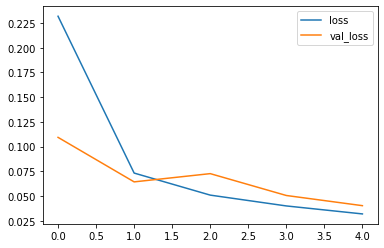

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()